### sentinel-3 altimetry data processing 

In [103]:
import numpy as np
from glob import glob
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster, hz01_hz20
from shapely.geometry import Point


In [120]:
path_geoid_cor = 'data/siling_co-lake/swot-pixc/raster_geoid_cor_smoothed.nc'
path_lake_vec = 'data/siling_co-lake/hydrolake_siling_co.gpkg'
paths_s3 = glob('data/siling_co-lake/s3/*/standard_measurement.nc')
paths_s3[0]


'data/siling_co-lake/s3/S3B_SR_2_LAN____20230728T040914_20230728T045943_20230821T080836_3029_082_147______PS2_O_NT_004.SEN3/standard_measurement.nc'

In [105]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_geoid_cor = xr.open_dataset(path_geoid_cor) 
raster_geoid_cor 
## read s3 altimetry data
s3_xr = xr.open_dataset(paths_s3[0])
s3_xr


<xarray.Dataset> Size: 33MB
Dimensions:                                        (time_01: 1728,
                                                    time_20_ku: 34591,
                                                    time_20_c: 33840)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 14kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 277kB ...
  * time_20_c                                      (time_20_c) datetime64[ns] 271kB ...
    lat_01                                         (time_01) float64 14kB ...
    lon_01                                         (time_01) float64 14kB ...
    lat_20_ku                                      (time_20_ku) float64 277kB ...
    lon_20_ku                                      (time_20_ku) float64 277kB ...
    lat_20_c                                       (time_20_c) float64 271kB ...
    lon_20_c                                       (time_20_c) float64 271kB ...
Data variables: (12/275)
    UTC_day_01                                     (time_01) datetime64[ns] 14kB ...
    UTC_sec_01                                     (time_01) float64 14kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 277kB ...
    UTC_sec_20_ku                                  (time_20_ku) float64 277kB ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 271kB ...
    UTC_sec_20_c                                   (time_20_c) float64 271kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 7kB ...
    num_20hz_meas_01_c                             (time_01) float32 7kB ...
    orbit_type_01                                  (time_01) float32 7kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 138kB ...
    iono_cor_alt_filtered_01_ku                    (time_01) float64 14kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float64 14kB ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3B
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3B_SR_2_RGI_AX_20230728T000000_202307...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230728T000000_202307...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230728T000000_202307...
    xref_altimeter_ltm:                S3B_SR_1_CA1LAX_20000101T000000_202308...
    xref_doris_uso:                    S3B_SR_1_USO_AX_20180501T144459_202308...
    xref_time_correlation:             S3B_AX___FRO_AX_20230728T000000_202308...

In [106]:
## 1. geophysical correction by refering to official document.
geo_corr_01hz=['mod_dry_tropo_cor_meas_altitude_01', 'mod_wet_tropo_cor_meas_altitude_01', 
                                        'iono_cor_gim_01_ku', 'load_tide_sol1_01', 
                                        'solid_earth_tide_01', 'pole_tide_01']
s3_geophy_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  s3_geophy_01hz += s3_xr[cor_01hz_name].values

## 2. Resample the 1Hz variables to 20Hz variables
times_20, times_01 = s3_xr['time_20_ku'].values, s3_xr['time_01'].values
s3_geophy_20hz = hz01_hz20(data_01hz=s3_geophy_01hz, time_01hz=times_01, time_20hz=times_20)
## 3. Calculate the corrected surface water height
## 3.1 ocog/ocean retracker
height_ocog = s3_xr['alt_20_ku'].values - s3_xr['range_ocog_20_ku'].values - s3_geophy_20hz


In [107]:
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(s3_xr['lon_cor_20_ku'].values, s3_xr['lat_cor_20_ku'].values)]
ids = np.where(lake_gdf.geometry[0].contains(points))[0]


In [108]:
raster_geoid_cor

<xarray.Dataset> Size: 281kB
Dimensions:             (y: 109, x: 160)
Coordinates:
  * x                   (x) float64 1kB 88.52 88.53 88.53 ... 89.35 89.36 89.36
  * y                   (y) float64 872B 32.03 32.02 32.02 ... 31.55 31.55 31.54
Data variables:
    geoid               (y, x) float64 140kB ...
    geoid_cor_smoothed  (y, x) float64 140kB ...

Text(0.5, 1.0, 'pixc Geoid')

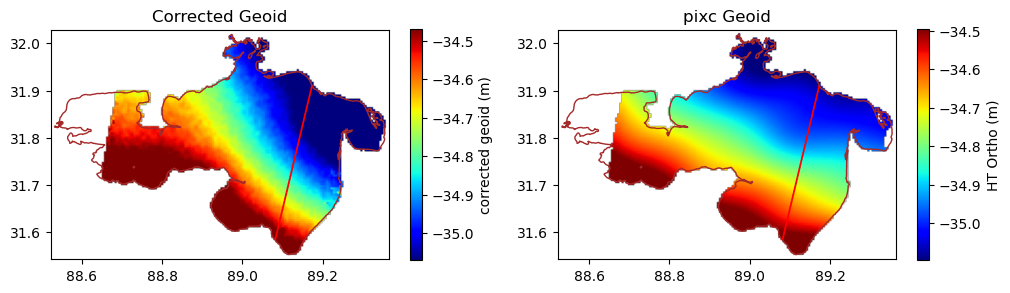

In [109]:
extent_raster = [raster_geoid_cor.x.min(), raster_geoid_cor.x.max(),
           raster_geoid_cor.y.min(), raster_geoid_cor.y.max()]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
geoid_mean = np.nanmean(raster_geoid_cor.geoid_cor_smoothed.values)
img_show1 = ax[0].imshow(raster_geoid_cor.geoid_cor_smoothed.values, cmap='jet', 
                        vmin = geoid_mean-0.3, vmax = geoid_mean+0.3, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=s3_xr['lon_20_ku'][ids], y=s3_xr['lat_20_ku'][ids], 
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)
ax[0].set_title('Corrected Geoid')
geoid_mean = np.nanmean(raster_geoid_cor.geoid.values)
img_show2 = ax[1].imshow(raster_geoid_cor.geoid.values, cmap='jet', 
                         vmin = geoid_mean-0.3, vmax = geoid_mean+0.3,
                         extent=extent_raster)
lake_gdf.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
scat2 = ax[1].scatter(x=s3_xr['lon_20_ku'][ids], y=s3_xr['lat_20_ku'][ids],                       
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show2, ax=ax[1], label='HT Ortho (m)', shrink=0.5)
ax[1].set_title('pixc Geoid')



In [110]:
## geoid correction
## sample the geoid correction raster to the S3 points
s3_geoid_cor = sample_from_raster(
        raster_value=raster_geoid_cor.geoid_cor_smoothed.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = s3_xr['lon_20_ku'][ids],
        points_y = s3_xr['lat_20_ku'][ids]
)

s3_geoid_sam = sample_from_raster(
        raster_value=raster_geoid_cor.geoid.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = s3_xr['lon_20_ku'].values[ids],
        points_y = s3_xr['lat_20_ku'].values[ids]
        )

s3_geoid_20hz = hz01_hz20(data_01hz=s3_xr['geoid_01'].values, time_01hz=times_01, time_20hz=times_20)
s3_height_geoid = height_ocog[ids] - s3_geoid_20hz[ids]
s3_height_geoid_cor = height_ocog[ids] - s3_geoid_cor


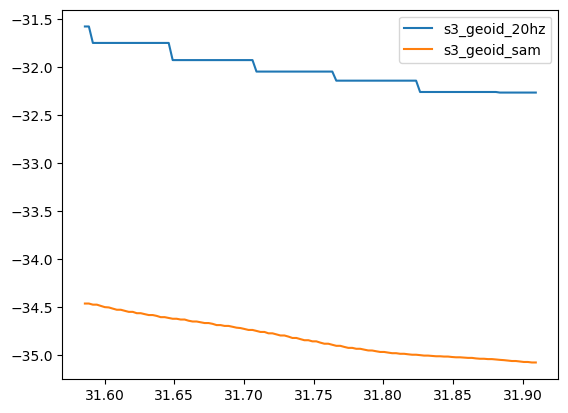

In [111]:
plt.plot(s3_xr['lat_20_ku'].values[ids], s3_geoid_20hz[ids], label='s3_geoid_20hz')
plt.plot(s3_xr['lat_20_ku'].values[ids], s3_geoid_sam, label='s3_geoid_sam')
plt.legend()

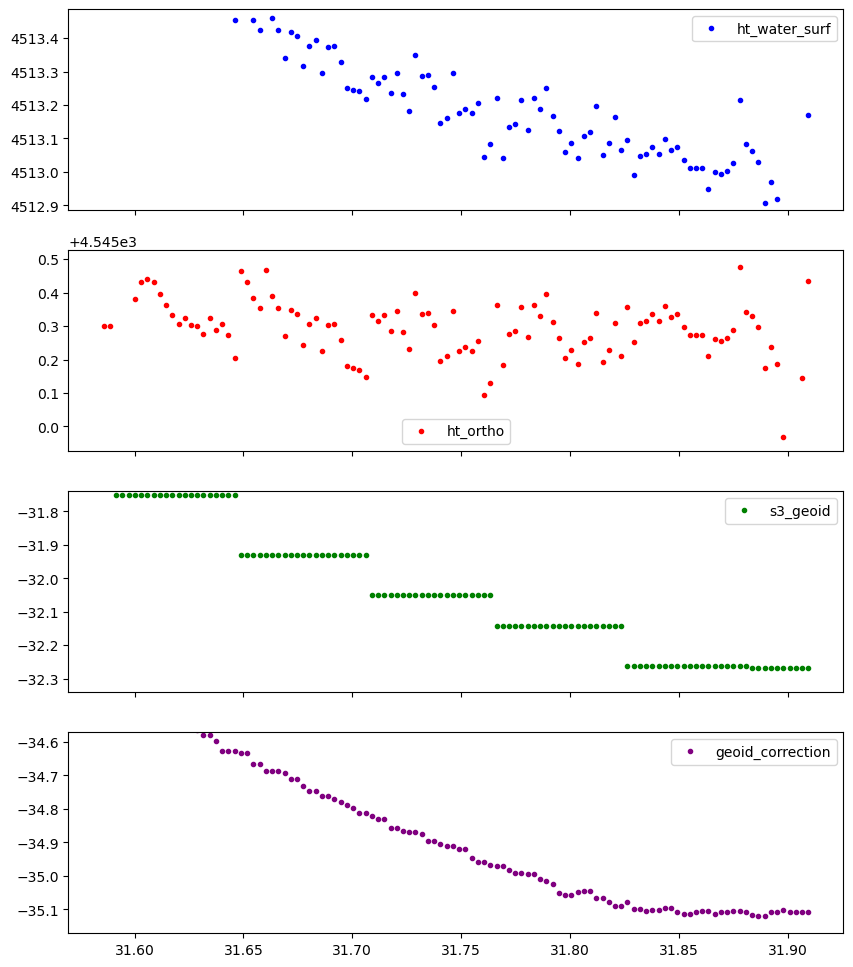

In [112]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
ht_mean = np.nanmean(height_ocog[ids])
ax[0].plot(s3_xr['lat_20_ku'].values[ids], height_ocog[ids], 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_water_surf')
ax[0].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[0].legend()

ht_mean = np.nanmean(s3_height_geoid)
ax[1].plot(s3_xr['lat_20_ku'].values[ids], s3_height_geoid, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[1].legend()
geoid_mean = np.mean(s3_geoid_20hz[ids])
ax[2].plot(s3_xr['lat_20_ku'].values[ids], s3_geoid_20hz[ids], 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='s3_geoid')
ax[2].set_ylim(geoid_mean - 0.3, geoid_mean + 0.3)
ax[2].legend()
geoid_mean = np.nanmean(s3_geoid_cor)
ax[3].plot(s3_xr['lat_20_ku'].values[ids], s3_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='geoid_correction')
ax[3].set_ylim(geoid_mean - 0.3, geoid_mean + 0.3)
ax[3].legend()


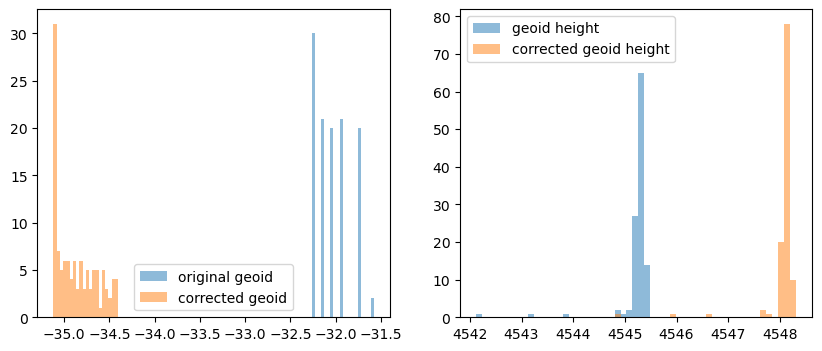

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(s3_geoid_20hz[ids], bins=20, alpha=0.5, label='original geoid');
ax[0].hist(s3_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid');
ax[0].legend();
ax[1].hist(s3_height_geoid, bins=30, alpha=0.5, label='geoid height');
ax[1].hist(s3_height_geoid_cor, bins=30, alpha=0.5, label='corrected geoid height');
ax[1].legend();


In [114]:
# Create an xarray.Dataset with both arrays
s3_height_geoid_ds = xr.Dataset(
  {
    "geoid": (("points",), s3_geoid_20hz[ids]),
    "geoid_cor": (("points",), s3_geoid_cor),
    "s3_height_geoid": (("points",), s3_height_geoid),
    "s3_height_geoid_cor": (("points",), s3_height_geoid_cor),
  },
  coords={
    "lat": (("points",), s3_xr['lat_20_ku'].values[ids]),
    "lon": (("points",), s3_xr['lon_20_ku'].values[ids]),
  })

# path_save = 'data/result/dianchi_s3_geoid_height.nc'
# s3_height_geoid_ds.to_netcdf(path_save, mode='w', format='NETCDF4')
s3_height_geoid_ds


<xarray.Dataset> Size: 5kB
Dimensions:              (points: 114)
Coordinates:
    lat                  (points) float64 912B 31.91 31.91 31.9 ... 31.59 31.59
    lon                  (points) float64 912B 89.17 89.17 89.17 ... 89.08 89.08
Dimensions without coordinates: points
Data variables:
    geoid                (points) float64 912B -32.27 -32.27 ... -31.58 -31.58
    geoid_cor            (points) float64 912B -35.11 -35.11 ... -34.41 -34.41
    s3_height_geoid      (points) float64 912B 4.545e+03 4.545e+03 ... 4.545e+03
    s3_height_geoid_cor  (points) float64 912B 4.548e+03 4.548e+03 ... 4.548e+03

In [115]:
print(np.nanstd(s3_height_geoid_ds['s3_height_geoid']))
print(np.nanstd(s3_height_geoid_ds['s3_height_geoid_cor']))


0.38536048174767806
0.40583787832818924


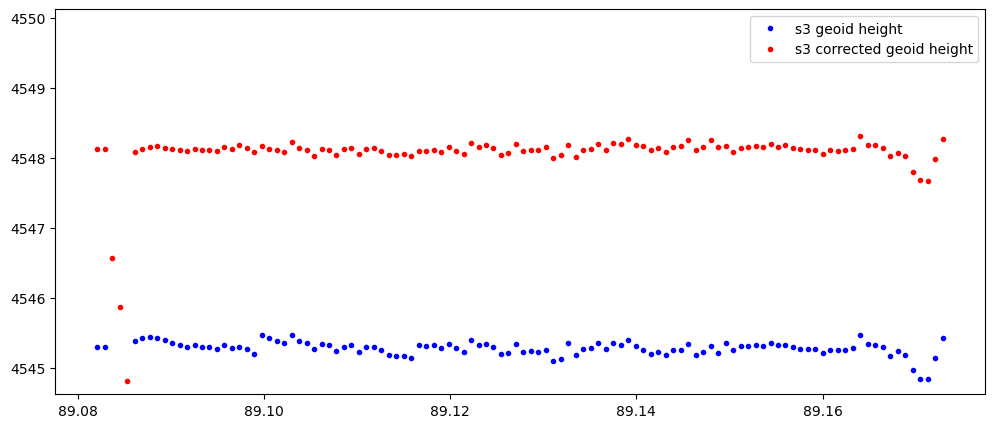

In [118]:
s3_height_geoid_median = np.nanmedian(s3_height_geoid_ds['s3_height_geoid_cor'])
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(s3_height_geoid_ds['lon'], s3_height_geoid_ds['s3_height_geoid'], 
         marker='o', markersize=3, linestyle='None', color='blue', label='s3 geoid height')

ax.plot(s3_height_geoid_ds['lon'], s3_height_geoid_ds['s3_height_geoid_cor'], 
         marker='o', markersize=3, linestyle='None', color='red', label='s3 corrected geoid height')

ax.set_ylim(s3_height_geoid_median-3.5, s3_height_geoid_median+2)
ax.legend()

